## This code implements a traveltime tomography using Physics Informed Neural Networks (PINN)





*   The aim is to invert traveltimes T(x) for velocity field v(x) using the following PDE (nonlinear first order) named eikonal equation:
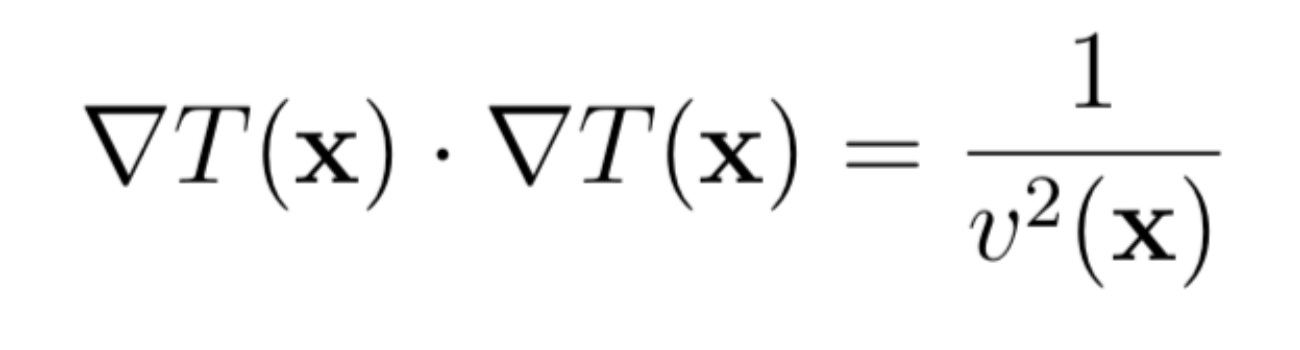




In the inversion framework PINN use two seperate neural networks and one loss term mainly consists of eikonal equation and the data mismatch (mismatch between the observed data and the modeled ones.)

Both the modeled traveltimes and the velocities are updated simultaneously until modeled traveltimes are fit the observed ones on the surface and satisfy the eikonal equation with the updated velocities on every points in the domain of interest.

The following scheme shows the PINN working mechanism for handling multiple shots:

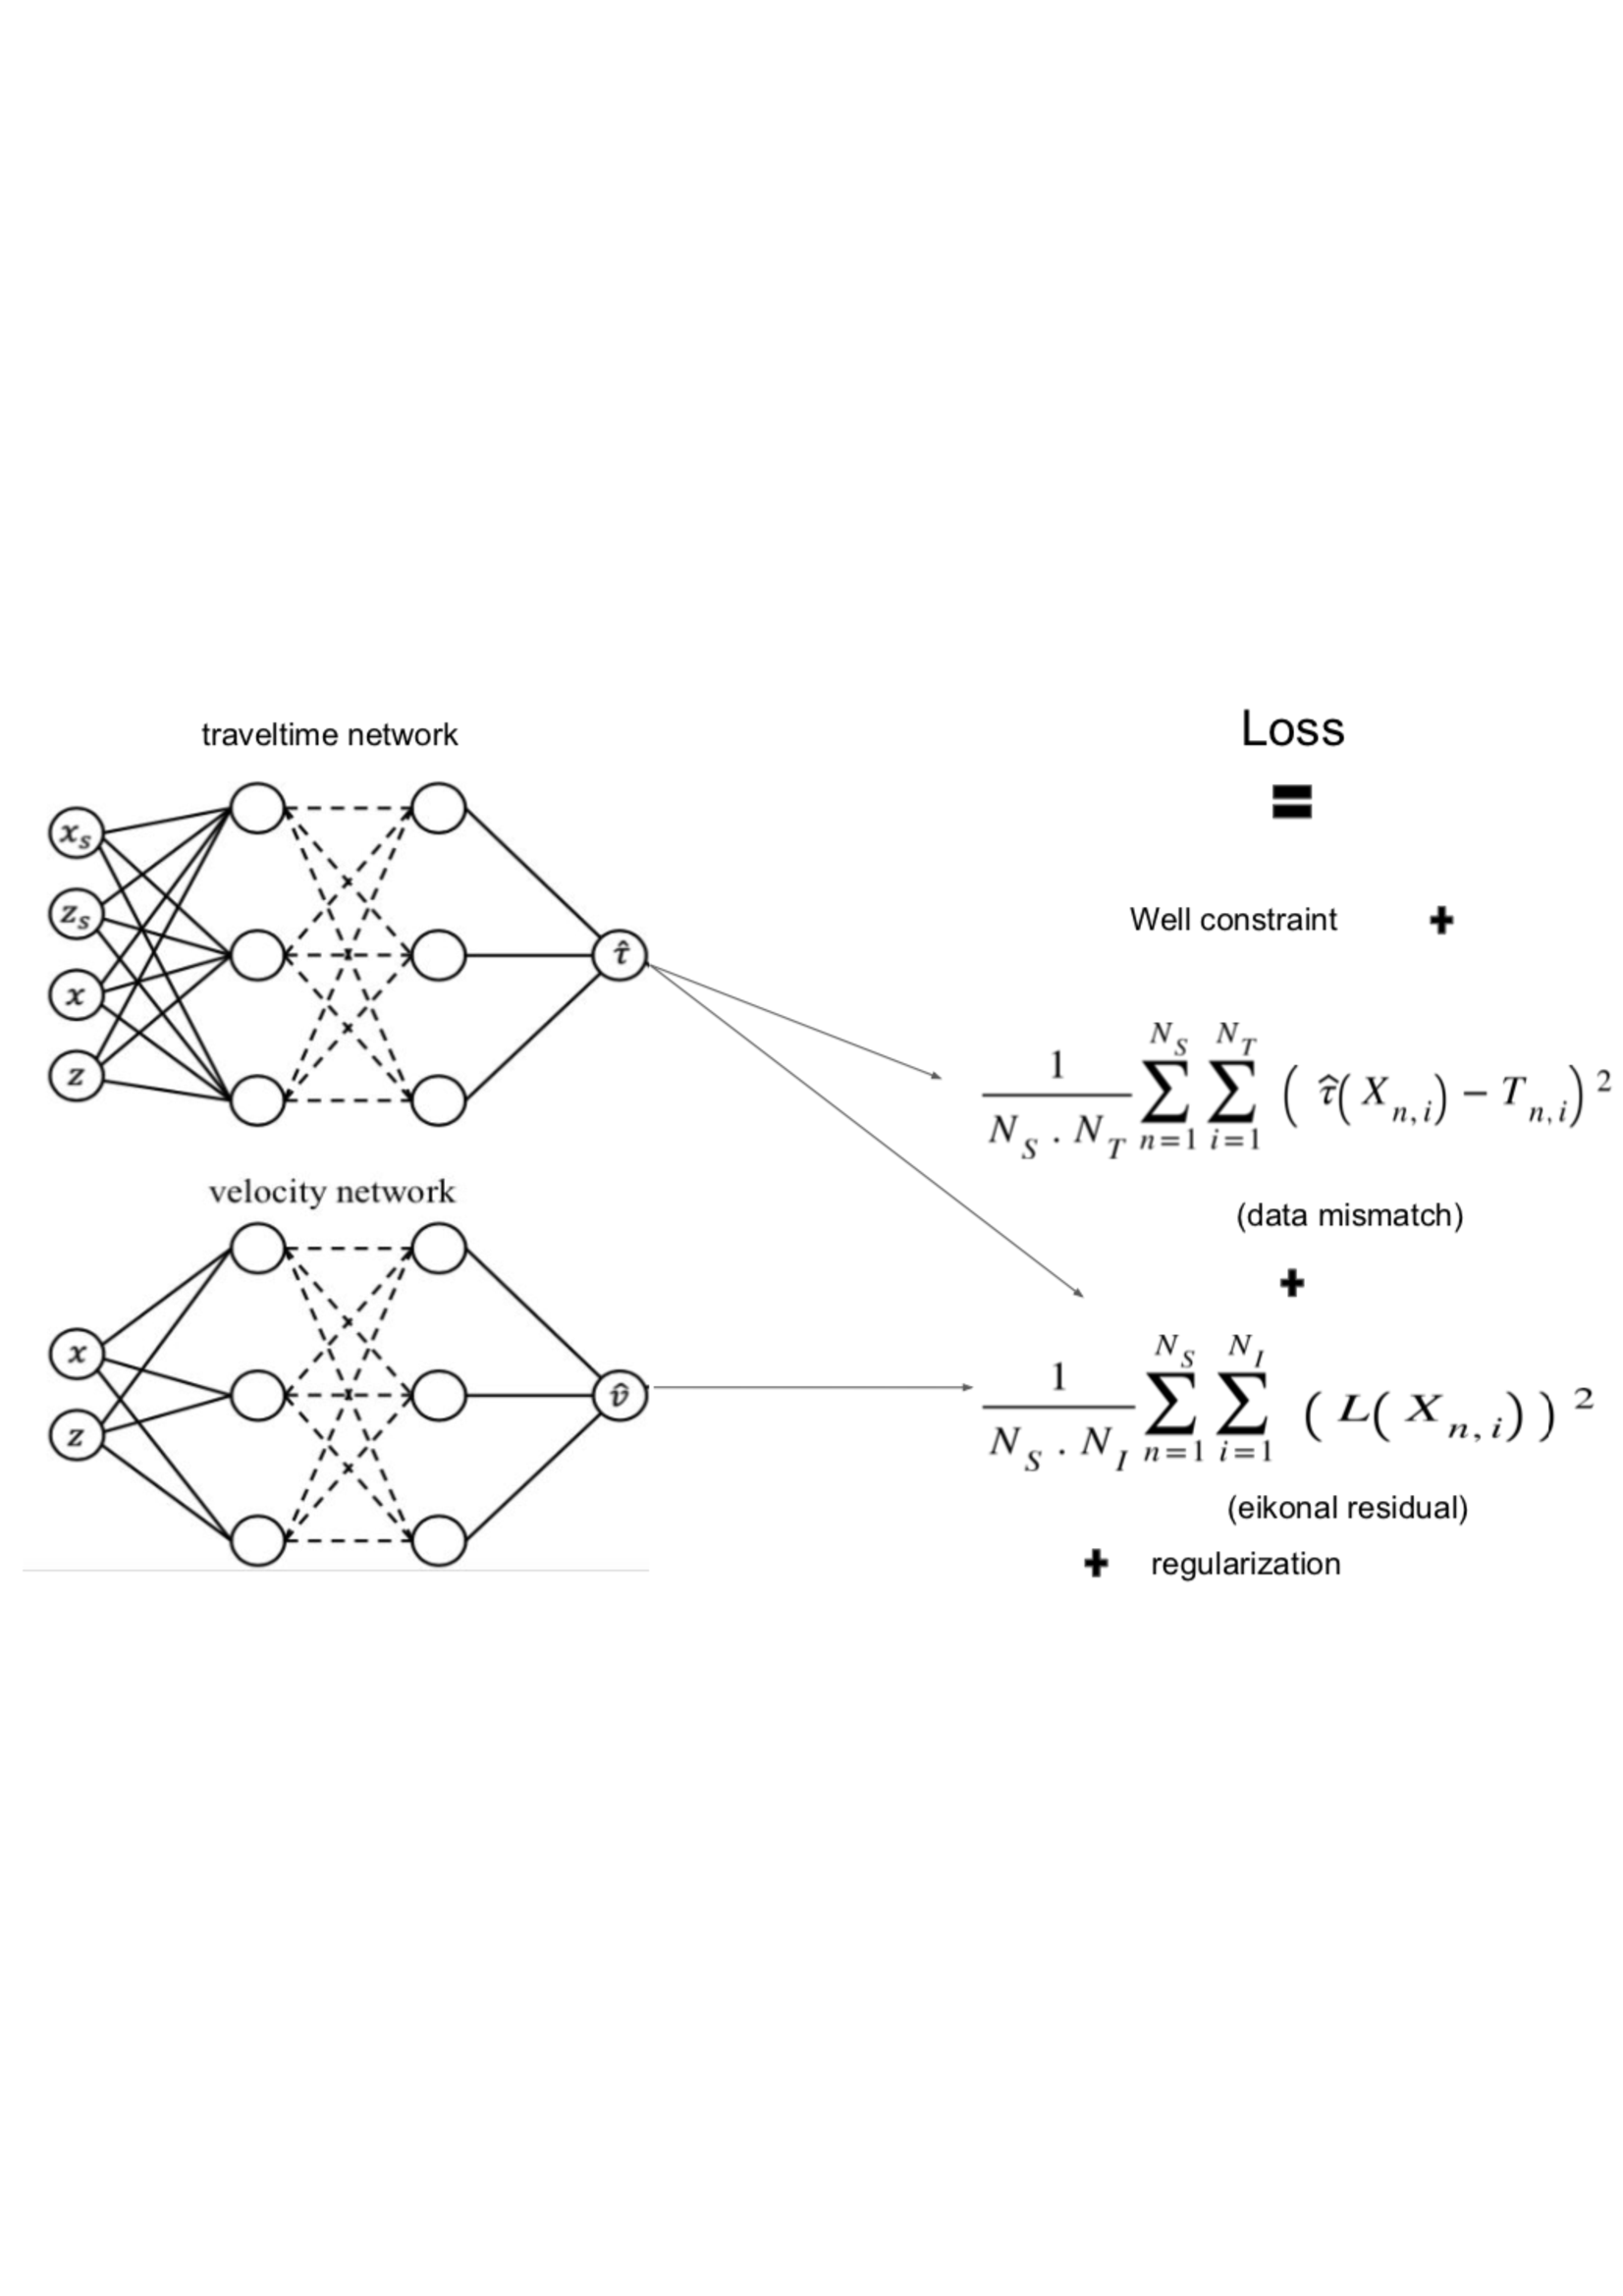

where Ns denotes the total number of sources, NT is the total number of receivers, and NI is the number of training (collocation) points from the computational domain. 

The constraint for the known well velocities is optional and is not used for this work.  Therefore the second term is the misfit between traveltimes predicted by the neural network and the observed traveltimes, T ̃n,i, over all sources and receivers. The third term ensures that the outputs of the neural networks minimize the residual of the eikonal equation over all sources and training points. For the regularization, total variation (TV) regularization is used. 





In [ ]:
# reaching google drive ...

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# tensorflow 1 is used for the implementation
%tensorflow_version 1.x    

TensorFlow 1.x selected.


In [ ]:
# import necessary libraries and modules ...

import tensorflow as tf
import numpy as np
import time
import matplotlib
matplotlib.rc('image', cmap='jet') 
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!pip install pydoe
from pyDOE import lhs

  Created wheel for pydoe: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=686f9002f341201bdf64a0d87be198b8e2cc988b79a205cc8272452053fe24e7
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pydoe


In [ ]:
# for reproducibility ...

tf.random.set_random_seed(1234)
np.random.seed(1234)

Read Velocity Model

In [ ]:
# change your path here...
velocity_model = pd.read_csv('/content/gdrive/MyDrive/pinn_new_test_models/marmousi_for_pinn.csv',header=None)
velocity_model = velocity_model.T.values

In [ ]:
velocity_model.shape

(188, 576)

In [ ]:
np.amax(velocity_model)

5.500105857849121

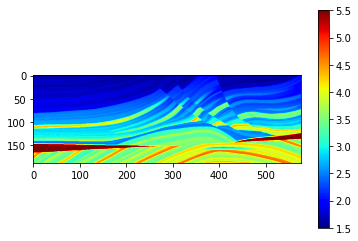

In [ ]:
plt.imshow(velocity_model)
plt.colorbar()


This synthetic velocity model is used for obtaining traveltimes.



*   Model size is 36x211 and both dx and dz are assumed to be the same and 10m. Therefore, the horizontal distance is 2.1 km and the depth extends to 0.35 km.

*   43 shots are used. The first sources start with the beginning of the model and the last one end at the end of the model. In each shot, all the surface receivers (211) are recording. Source distances are 50m and regular, which makes it a total of 43 sources.




Read Surface Traveltimes

In [ ]:
# change your path here...
first_arrival_data = pd.read_csv('/content/gdrive/MyDrive/pinn_new_test_models/marmousi_pinn_traveltimes.csv',header=None)
first_arrival_data = first_arrival_data.values

In [ ]:
np.amax(first_arrival_data[0])

3.599782228469849

Creating domain coordinates and training data coordinates that will handle multiple shots.

In the following code y is assumed to be the depth axis and x is horizontal axis.

In [ ]:
# shot and receiver numbers
shot_num = 43
rec_num = 211 
source_shift = 0.05

In [ ]:
x = np.arange(0,2.11,0.01)[:,None]
y = np.arange(0,0.36,0.01)[:,None]
X_m, Y_m = np.meshgrid(x,y)
X = X_m.flatten()
Y = Y_m.flatten()
X_predict = X_m.flatten()[:,None] # use for prediction
Y_predict = Y_m.flatten()[:,None] # use for prediction
X_rep = np.tile(X, shot_num)[:,None] # shot number times replecated X 
Y_rep = np.tile(Y, shot_num)[:,None] # shot number times replecated Y

In [ ]:
# create source data for the first shot
xs = np.array([0])
xs = np.tile(xs,len(X))

# create source data for the others
for sn in np.arange(source_shift, 2.1 + source_shift, source_shift):  
  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep = np.array([sn])
  rep = np.tile(rep,len(X))
  xs = np.concatenate((xs,rep))
ys = np.zeros(len(xs)) # surface y coordinates are all 0

Xs = xs[:,None] # corresponds to X_rep
Ys = ys[:,None] # corresponds to Y_rep


In [ ]:
# training data
T_train = first_arrival_data[window].flatten()
T_train = T_train[:,None]

In [ ]:
# create source coordinates for training data

# create source data for the first shot
xst = np.array([0])
xst = np.tile(xst,rec_num)

# create source data for the others
for sn in np.arange(source_shift, 2.1 +source_shift, source_shift): 

  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep = np.array([sn])
  rep = np.tile(rep,rec_num)
  xst = np.concatenate((xst,rep))
yst = np.zeros(len(xst)) # surface y coordinates are all 0

Xst = xst[:,None] # corresponds to T_train
Yst = yst[:,None] # corresponds to T_train

In [ ]:
# create x and y coordinates corresponds the training data
xtrain = np.arange(0,2.11,0.01) # receiver coordinates 
ytrain = np.zeros(len(xtrain)) # surface y coordinates are all 0

xtrain_rep = np.tile(xtrain,shot_num)
ytrain_rep = np.zeros(len(xtrain_rep)) # surface y coordinates are all 0
X_train = xtrain_rep[:,None] # corresponds to T_train
Y_train = ytrain_rep[:,None] # corresponds to T_train




Class that executes the PINN enabled inversion. 

This class is the modified version of the code in
[link text](https://github.com/fsahli/EikonalNet)

In [ ]:
class Pinn_inv:
    # Initialize the class
    def __init__(self, x, y, xsource, ysource, x_e, y_e, xse, yse, T_e, layers, CVlayers, C = 1.0, alpha = 1e-5, alphaL2 = 1e-6, jobs = 4):
        
        X = np.concatenate([x, y, xsource], 1)
        XV = np.concatenate([x, y], 1)

        
        self.lb = X.min(0)
        self.ub = X.max(0)
        self.lbv = XV.min(0)
        self.ubv = XV.max(0)
                
        self.X = X
        self.XV = XV


        self.x = x
        self.y = y

        #self.xswell = xswell
        #self.yswell = yswell
        #self.yswell = yswell
        #self.ywell = ywell


        self.xsource = xsource
        #self.ysource = ysource
        self.xse = xse
        #self.yse = yse


        self.T_e = T_e
        self.x_e = x_e
        self.y_e = y_e
        #self.Vwell = Vwell
        
        self.layers = layers
        self.CVlayers = CVlayers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers) 

        #self.weights = weights
        #self.biases = biases


        # initialize the velocity NN weights.
        self.CVweights, self.CVbiases = self.initialize_NN(CVlayers) 

        #self.CVweights = CVweights
        #self.CVbiases = CVbiases


    

        self.C = tf.constant(C)
        self.alpha = tf.constant(alpha)
        self.alphaL2 = alphaL2
        
        

        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True,
                                                     intra_op_parallelism_threads=jobs,
                                                     inter_op_parallelism_threads=jobs,
                                                     device_count={'CPU': jobs}))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])

        #self.xswell_tf = tf.placeholder(tf.float32, shape=[None, self.xswell.shape[1]])
        #self.yswell_tf = tf.placeholder(tf.float32, shape=[None, self.yswell.shape[1]])
        
        #self.xwell_tf = tf.placeholder(tf.float32, shape=[None, self.xwell.shape[1]])
        #self.ywell_tf = tf.placeholder(tf.float32, shape=[None, self.ywell.shape[1]])



        self.xsource_tf = tf.placeholder(tf.float32, shape=[None, self.xsource.shape[1]])
        #self.ysource_tf = tf.placeholder(tf.float32, shape=[None, self.ysource.shape[1]])
        self.xse_tf = tf.placeholder(tf.float32, shape=[None, self.xse.shape[1]])
        #self.yse_tf = tf.placeholder(tf.float32, shape=[None, self.yse.shape[1]])
        
        self.T_e_tf = tf.placeholder(tf.float32, shape=[None, self.T_e.shape[1]]) 
        self.x_e_tf = tf.placeholder(tf.float32, shape=[None, self.x_e.shape[1]]) 
        self.y_e_tf = tf.placeholder(tf.float32, shape=[None, self.y_e.shape[1]]) 
        #self.Vwell_tf = tf.placeholder(tf.float32, shape=[None, self.Vwell.shape[1]]) 

      
  


        

        self.T_pred, self.CV_pred, self.f_T_pred, self.f_CV_pred  = self.net_eikonal(self.x_tf, self.y_tf, self.xsource_tf )
                
        self.T_e_pred, self.CV_e_pred, self.f_T_e_pred, self.f_CV_e_pred = self.net_eikonal(self.x_e_tf, self.y_e_tf, self.xse_tf)

        #self.T_well_pred, self.CV_well_pred, self.f_T_well_pred, self.f_CV_well_pred = self.net_eikonal(self.xwell_tf, self.ywell_tf, self.xswell_tf)

                       
        #self.loss = tf.reduce_mean(tf.square(self.T_e_tf - self.T_e_pred)) + \
        #            tf.reduce_mean(tf.square(self.Vwell_tf - self.CV_well_pred)) + \
        #            tf.reduce_mean(tf.square(self.f_T_e_pred)) + \
        #            tf.reduce_mean(tf.square(self.f_T_pred)) + \
        #            tf.reduce_mean(tf.square(self.f_T_well_pred)) + \
        #            self.alpha*tf.reduce_mean(tf.square(self.f_CV_well_pred)) + \
        #            self.alpha*tf.reduce_mean(tf.square(self.f_CV_e_pred)) + \
        #            self.alpha*tf.reduce_mean(tf.square(self.f_CV_pred)) + \
        #            sum([self.alphaL2*tf.nn.l2_loss(w) for w in self.weights])

        self.loss = 100*tf.reduce_mean(tf.square(self.T_e_tf - self.T_e_pred)) + \
                    tf.reduce_mean(tf.square(self.f_T_pred)) + \
                    tf.reduce_mean(tf.square(self.f_T_e_pred)) + \
                    self.alpha*tf.reduce_mean(tf.square(self.f_CV_e_pred)) + \
                    self.alpha*tf.reduce_mean(tf.square(self.f_CV_pred)) 
    
     
                    

                 
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list= self.CVweights + self.CVbiases + self.weights + self.biases) 
        # Define optimizer (use L-BFGS for faster convergence)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                var_list= self.CVweights + self.CVbiases + self.weights + self.biases,
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 30000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)


    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_vel(self, XV, weights, biases):


        num_layers = len(weights) + 1
        
        H = 2.0*(XV - self.lbv)/(self.ubv - self.lbv) - 1.0
        
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

  


    def net_eikonal(self, x, y, xsource):
        C = self.C
        T = self.neural_net(tf.concat([x,y,xsource], 1), self.weights, self.biases)
        CV = self.neural_net_vel(tf.concat([x,y], 1), self.CVweights, self.CVbiases)

      

        
        CV = C*tf.sigmoid(CV)

        T = 3.6*tf.sigmoid(T)

        
        T_x = tf.gradients(T, x)[0]
        T_y = tf.gradients(T, y)[0]
        
        CV_x = tf.gradients(CV, x)[0]
        CV_y = tf.gradients(CV, y)[0]

        
        f_T = tf.sqrt(T_x**2 + T_y**2) - 1.0/CV
        f_CV = tf.sqrt(CV_x**2 + CV_y**2)


        return T, CV, f_T, f_CV
        

    
    def callback(self, loss):
        self.lossit.append(loss)
        print('Loss: %.5e' % (loss))
      
    def train(self): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource,
                   self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e} 

        #tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource,  self.xswell_tf: self.xswell, self.xwell_tf: self.xwell, self.ywell_tf: self.ywell,
        #           self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e, self.Vwell_tf: self.Vwell}
        
        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def train_Adam(self, nIter): 
        
        self.lossit = []

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource,
                   self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}  
        #tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource,  self.xswell_tf: self.xswell, self.xwell_tf: self.xwell, self.ywell_tf: self.ywell,
        #           self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e, self.Vwell_tf: self.Vwell}           

        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                C_value = np.exp(self.sess.run(self.C))
                print('It: %d, Loss: %.3e, C: %.3f, Time: %.2f' % 
                      (it, loss_value, C_value, elapsed))
                start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        return self.lossit
        


    def train_Adam_minibatch(self, nIter, size = 50): 
        
        self.lossit = []
       
        start_time = time.time()
        for it in range(nIter):
            X = lhs(2, size)
            XS = np.random.choice(np.arange(0, 9.2 + 0.016, 0.016)[np.arange(0,576,64)],size)[:,None]
            tf_dict = {self.x_tf: 9.2*X[:,:1], self.y_tf: 2.992*X[:,1:], self.xsource_tf: XS,
                    self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}  
            #tf_dict = {self.x_tf: X[:,:1], self.y_tf: X[:,1:],self.xsource_tf: self.xsource,  self.xswell_tf: self.xswell, self.xwell_tf: self.xwell, self.ywell_tf: self.ywell,
            #           self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e, self.Vwell_tf: self.Vwell}   
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                C_value = np.exp(self.sess.run(self.C))
                print('It: %d, Loss: %.3e, C: %.3f, Time: %.2f' % 
                      (it, loss_value, C_value, elapsed))
                start_time = time.time()  

        return self.lossit                       
            
    def predict(self, x_star, y_star):
        
        #tf_dict = {self.x_tf: x_star, self.y_tf: x_star, self.xsource_tf: self.xsource, self.ysource_tf: self.ysource,
        #           self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.yse_tf: self.yse}
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.xsource_tf: self.xsource,
                   self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse}

        T_star2 = self.sess.run(self.T_pred, tf_dict)
        CV_star2 = self.sess.run(self.CV_pred, tf_dict)
        NNtweights = self.sess.run(self.weights, tf_dict)
        NNtbiases = self.sess.run(self.biases, tf_dict)
        NNvweights = self.sess.run(self.CVweights, tf_dict)
        NNvbiases = self.sess.run(self.CVbiases, tf_dict)
       


        
        return T_star2, CV_star2, NNtweights, NNtbiases, NNvweights, NNvbiases

In [ ]:
#########################    CALLING THE CLASS  ###############################

#layers = [3,50,50,50,50,50,1]  # traveltime NN structure
#CVlayers = [2,20,20,20,20,1]   # velocity NN structure

layers = [3,50,50,50,50,50,50,50,1]
CVlayers = [2,50,50,50,50,50,1]

# collocation points
X_pde = X_rep
Y_pde = Y_rep

# maximum value for the velocity model
CVmax = 5.5

model = Pinn_inv(X_pde, Y_pde, Xs, Ys, X_train, Y_train, Xst, Yst, T_train, 
                layers, CVlayers, C = CVmax, alpha = 1e-8 , alphaL2 = 0. )

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
#saved_loss = model.train_Adam(1000)
#saved_loss = model.train_Adam_minibatch(20000, size = 300)
model.train() # BFGS training

Loss: 6.99379e-03
Loss: 3.10252e+02
Loss: 6.10331e-03
Loss: 5.32974e-03
Loss: 4.56165e-03
Loss: 4.23289e-03
Loss: 4.04715e-03
Loss: 3.96852e-03
Loss: 3.85339e-03
Loss: 3.83496e-03
Loss: 3.81930e-03
Loss: 3.80764e-03
Loss: 3.78329e-03
Loss: 3.76451e-03
Loss: 3.72250e-03
Loss: 3.70607e-03
Loss: 3.68115e-03
Loss: 3.67245e-03
Loss: 3.66404e-03
Loss: 3.63986e-03
Loss: 3.61697e-03
Loss: 3.59321e-03
Loss: 3.57624e-03
Loss: 3.56729e-03
Loss: 3.55816e-03
Loss: 3.55010e-03
Loss: 3.53215e-03
Loss: 3.52353e-03
Loss: 3.51216e-03
Loss: 3.50677e-03
Loss: 3.50093e-03
Loss: 3.49738e-03
Loss: 3.49244e-03
Loss: 3.48621e-03
Loss: 3.48376e-03
Loss: 3.48232e-03
Loss: 3.47992e-03
Loss: 3.47701e-03
Loss: 3.47269e-03
Loss: 3.46851e-03
Loss: 3.46538e-03
Loss: 3.46340e-03
Loss: 3.46120e-03
Loss: 3.45573e-03
Loss: 3.44827e-03
Loss: 3.44177e-03
Loss: 3.43777e-03
Loss: 3.43542e-03
Loss: 3.43124e-03
Loss: 3.42680e-03
Loss: 3.41929e-03
Loss: 3.41240e-03
Loss: 3.40663e-03
Loss: 3.40248e-03
Loss: 3.39909e-03
Loss: 3.39

KeyboardInterrupt: ignored

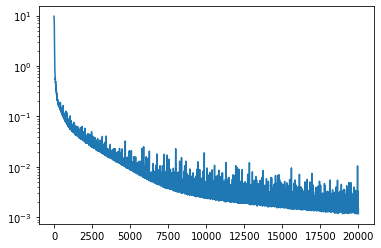

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(saved_loss[0:20000])
ax.set_yscale('log')

In [ ]:
saved_loss = model.train_Adam_minibatch(75000,300)
model.train() # BFGS training

Streaming output truncated to the last 5000 lines.
Loss: 7.33178e-05
Loss: 7.33124e-05
Loss: 7.33099e-05
Loss: 7.33053e-05
Loss: 7.33218e-05
Loss: 7.33032e-05
Loss: 7.33012e-05
Loss: 7.32965e-05
Loss: 7.32935e-05
Loss: 7.32921e-05
Loss: 7.32877e-05
Loss: 7.32861e-05
Loss: 7.32826e-05
Loss: 7.32793e-05
Loss: 7.32729e-05
Loss: 7.32689e-05
Loss: 7.32650e-05
Loss: 7.32620e-05
Loss: 7.32582e-05
Loss: 7.32531e-05
Loss: 7.32520e-05
Loss: 7.32470e-05
Loss: 7.32461e-05
Loss: 7.32432e-05
Loss: 7.32398e-05
Loss: 7.32371e-05
Loss: 7.32331e-05
Loss: 7.32312e-05
Loss: 7.32293e-05
Loss: 7.32253e-05
Loss: 7.32243e-05
Loss: 7.32199e-05
Loss: 7.32235e-05
Loss: 7.32176e-05
Loss: 7.32140e-05
Loss: 7.32109e-05
Loss: 7.32088e-05
Loss: 7.32055e-05
Loss: 7.32018e-05
Loss: 7.31985e-05
Loss: 7.31948e-05
Loss: 7.31916e-05
Loss: 7.31879e-05
Loss: 7.31818e-05
Loss: 7.31773e-05
Loss: 7.31747e-05
Loss: 7.31701e-05
Loss: 7.31673e-05
Loss: 7.31648e-05
Loss: 7.31596e-05
Loss: 7.31526e-05
Loss: 7.31621e-05
Loss: 7.31493

In [ ]:
T_star, CV_star, vweights, vbiases, tweights, tbiases  = model.predict(X_rep,Y_rep)


In [ ]:
CV_star = CV_star[0:len(X_predict),:]


In [ ]:
CV_star = np.reshape(CV_star, (36, 211))

In [ ]:
CV_star = np.reshape(CV_star, (188, 576))

In [ ]:
CV_star = CV_star[0:85,157:465]

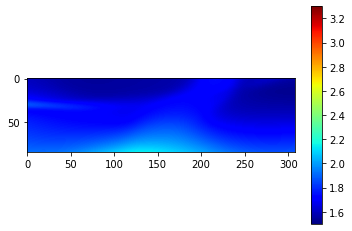

In [ ]:
plt.imshow(CV_star)
plt.colorbar()
plt.clim(1.5,3.3)



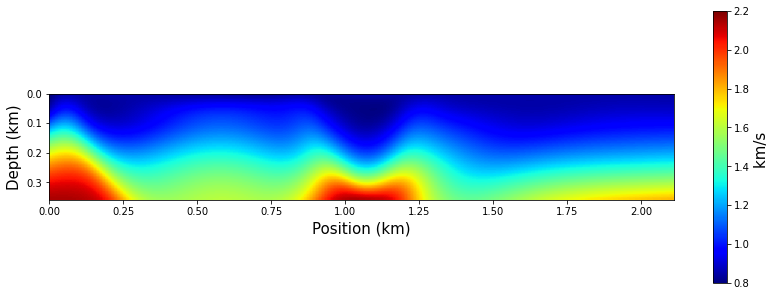

In [ ]:
fig = plt.figure()
fig.set_size_inches((14,5))
plt.subplot(111)
plt.imshow(CV_star,extent = [0 ,2.11 , 0.36, 0])
plt.xlabel('Position (km)',  fontsize=15)
plt.ylabel('Depth (km)',  fontsize=15)
cbar = plt.colorbar()
plt.clim(0.8,2.2)
cbar.set_label(  'km/s ', rotation=90,  fontsize=15)

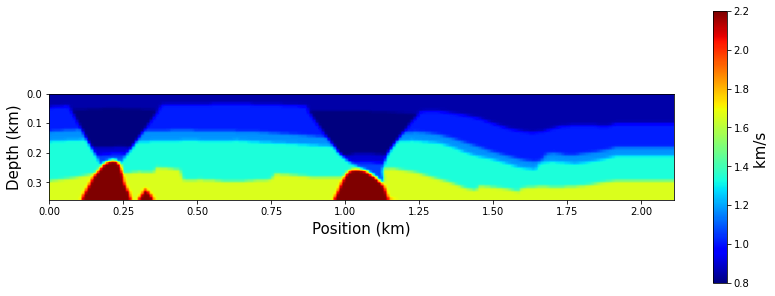

In [ ]:
fig = plt.figure()
fig.set_size_inches((14,5))
plt.subplot(111)
plt.imshow(velocity_model,extent = [0 ,2.11 , 0.36, 0])
plt.xlabel('Position (km)',  fontsize=15)
plt.ylabel('Depth (km)',  fontsize=15)
cbar = plt.colorbar()
plt.clim(0.8,2.2)
cbar.set_label(  'km/s ', rotation=90,  fontsize=15)

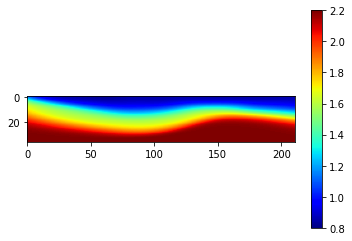

In [ ]:
plt.imshow(CV_star)
plt.colorbar()
plt.clim(0.8,2.2)

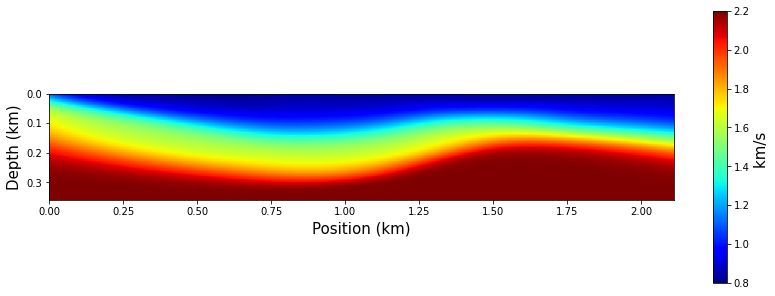

In [ ]:
fig = plt.figure()
fig.set_size_inches((14,5))
plt.subplot(111)
plt.imshow(CV_star,extent = [0 ,2.11 , 0.36, 0])
plt.xlabel('Position (km)',  fontsize=15)
plt.ylabel('Depth (km)',  fontsize=15)
cbar = plt.colorbar()
plt.clim(0.8,2.2)
cbar.set_label(  'km/s ', rotation=90,  fontsize=15)

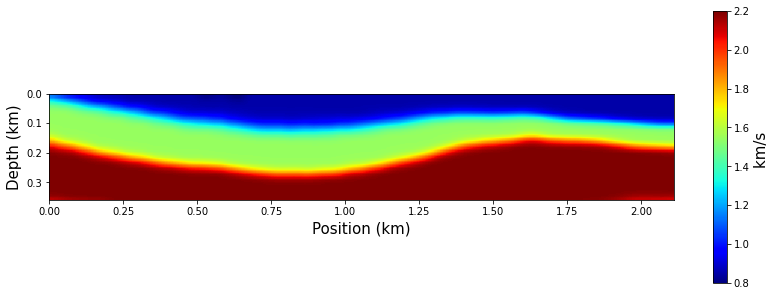

In [ ]:
fig = plt.figure()
fig.set_size_inches((14,5))
plt.subplot(111)
plt.imshow(velocity_model,extent = [0 ,2.11 , 0.36, 0])
plt.xlabel('Position (km)',  fontsize=15)
plt.ylabel('Depth (km)',  fontsize=15)
cbar = plt.colorbar()
plt.clim(0.8,2.2)
cbar.set_label(  'km/s ', rotation=90,  fontsize=15)

In [ ]:
tomo = pd.read_csv('/content/gdrive/MyDrive/pinn_new_test_models/modelexamp_tomo1.csv',header=None)
tomo = tomo.T.values

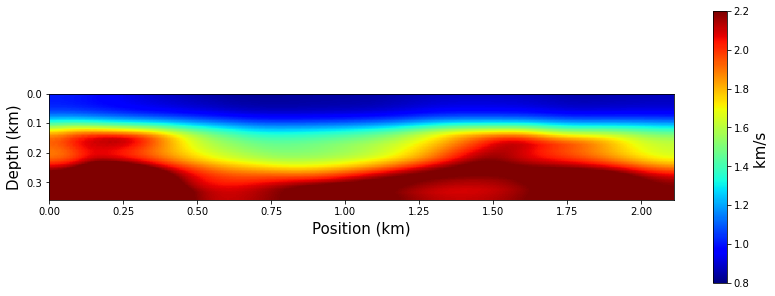

In [ ]:
fig = plt.figure()
fig.set_size_inches((14,5))
plt.subplot(111)
plt.imshow(tomo,extent = [0 ,2.11 , 0.36, 0])
plt.xlabel('Position (km)',  fontsize=15)
plt.ylabel('Depth (km)',  fontsize=15)
cbar = plt.colorbar()
plt.clim(0.8,2.2)
cbar.set_label(  'km/s ', rotation=90,  fontsize=15)

Below I compare the true and the inverted model:

It can be seen that the PINN inversion retrieves the velocities reliably.

True Velocity Model

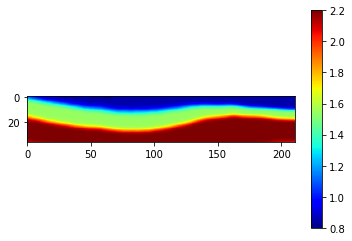






PINN Predicted Velocity Model

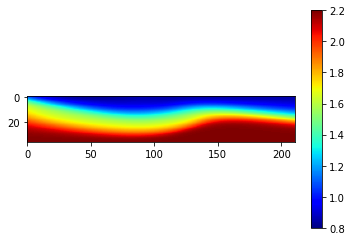